In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt


In [80]:
final_prostate_data = pd.read_csv("final_prostate_data.csv")


# Filter the dataset for classes 1 and 2 in "PROSTCAN_A"
filtered_data = final_prostate_data[final_prostate_data['PROSTCAN_A'].isin([1, 2])]




final_prostate_data = pd.read_csv("final_prostate_data.csv")

# Separate features and target
X = final_prostate_data.drop('PROSTCAN_A', axis=1)
y = final_prostate_data['PROSTCAN_A']

In [81]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = ['AGEP_A']  # Assuming 'AGEP_A' is the only numerical column

# Define transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# For example, keeping only classes 1 and 2
classes_to_keep = [1, 2]

filtered_data = final_prostate_data[final_prostate_data['PROSTCAN_A'].isin(classes_to_keep)]

In [83]:
# For example, keeping only classes 1 and 2
classes_to_keep = [1, 2]

filtered_data = final_prostate_data[final_prostate_data['PROSTCAN_A'].isin(classes_to_keep)]

In [84]:
X_filtered = filtered_data.drop('PROSTCAN_A', axis=1)
y_filtered = filtered_data['PROSTCAN_A']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)


In [86]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [87]:
#Create a pipeline for the Decision Tree model
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

dt_pipeline.fit(X_train, y_train_encoded)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGEP_A']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='obje

In [88]:
#Verify if y_train_encoded is binary
print(np.unique(y_train_encoded))

# If y_train_encoded is not binary, use a different scoring metric
if len(np.unique(y_train_encoded)) > 2:
    scoring_metric = 'accuracy'  # For multi-class classification
else:
    scoring_metric = 'roc_auc'   # For binary classification

# Perform cross-validation with the appropriate scoring metric
cv_scores = cross_val_score(dt_pipeline, X_train, y_train_encoded, cv=5, scoring=scoring_metric)
print("Cross-Validation Scores:", cv_scores)
print("Mean Score:", cv_scores.mean())

[0 1]
Cross-Validation Scores: [0.63145288 0.66105819 0.6384231  0.64489495 0.64710569]
Mean Score: 0.6445869604204892


In [89]:
y_pred = dt_pipeline.predict(X_test)
y_pred_proba = dt_pipeline.predict_proba(X_test)[:, 1]
test_auc_score = roc_auc_score(y_test_encoded, y_pred_proba)
test_accuracy = accuracy_score(y_test_encoded, y_pred)
print("Test AUC Score:", test_auc_score)
print("Test Accuracy:", test_accuracy)

Test AUC Score: 0.6556509194862259
Test Accuracy: 0.7054054054054054


In [90]:
from sklearn.metrics import make_scorer, f1_score

# Custom scorer for F1 score
f1_scorer = make_scorer(f1_score, average='binary')  # Use 'binary' for binary classification

# Perform cross-validation with F1 scoring metric
cv_f1_scores = cross_val_score(dt_pipeline, X_train, y_train_encoded, cv=5, scoring=f1_scorer)
print("Cross-Validation F1 Scores:", cv_f1_scores)
print("Mean F1 Score:", cv_f1_scores.mean())

Cross-Validation F1 Scores: [0.82929243 0.82888229 0.82830282 0.82970297 0.82929243]
Mean F1 Score: 0.8290945888842691


In [91]:
from sklearn.metrics import confusion_matrix

# Fit the model on the whole training set
dt_pipeline.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred = dt_pipeline.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)  # Also known as recall
specificity = tn / (tn + fp)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

Sensitivity (Recall): 0.997134670487106
Specificity: 0.0


In [92]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print(classification_report(y_train_encoded, y_train_pred))

              precision    recall  f1-score   support

           0       0.80      0.00      0.00      1730
           1       0.71      1.00      0.83      4190

    accuracy                           0.71      5920
   macro avg       0.75      0.50      0.42      5920
weighted avg       0.74      0.71      0.59      5920



In [93]:
# Predict on the test data
y_test_pred = dt_pipeline.predict(X_test)

In [94]:
from sklearn.metrics import classification_report

# Generate and print the classification report for the test data
print(classification_report(y_test_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       433
           1       0.71      1.00      0.83      1047

    accuracy                           0.71      1480
   macro avg       0.35      0.50      0.41      1480
weighted avg       0.50      0.71      0.59      1480



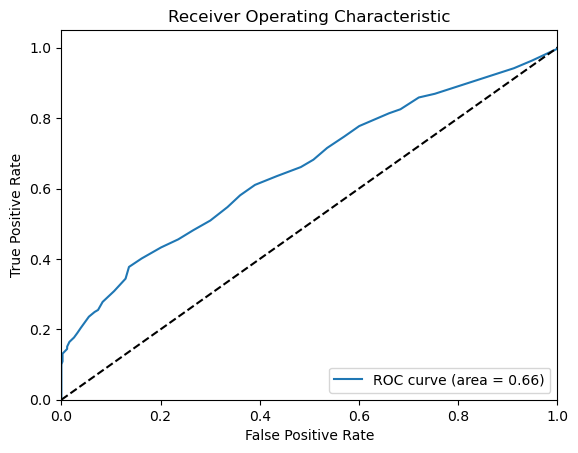

In [97]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % test_auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()